In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import model_function
import math

Load a model or create a new one?

In [257]:
load = False
model_path ='models/2024-01-08_14-17-45_3exp_params_517_points_50/model.keras'

In [258]:
X_train = np.load('outputs/x_train_current.npy')
# df = pd.read_csv('measurements/E_4_20ms_20231103_14_55_46.csv', sep=', ')
X_train = X_train[:,:,-1]
X_train

array([[1.16041279, 1.06097543, 1.06097543, 1.06097543, 1.16041279],
       [1.0277909 , 1.0603317 , 1.0277909 , 1.0277909 , 1.09408748],
       [1.09408748, 1.06097543, 1.02841461, 1.0603317 , 1.16041279],
       [1.16041279, 1.02904403, 1.16041279, 1.02904403, 1.16041279],
       [1.06097543, 1.06097543, 1.16041279, 1.02904403, 1.02904403],
       [1.16041279, 1.02658641, 1.16041279, 1.02904403, 1.16041279],
       [1.16041279, 1.02658641, 1.16041279, 1.06097543, 1.16041279],
       [1.16041279, 1.02904403, 1.02904403, 1.02904403, 1.02904403],
       [1.16041279, 1.06097543, 1.16041279, 1.06097543, 1.16041279],
       [1.16041279, 1.06097543, 1.16041279, 1.02904403, 1.16041279]])

In [259]:
y_train= np.zeros((X_train.shape[0], 10))
j = 0
for i in range(10):
    y_train[j,i]=1
    j+=1

In [260]:
X_test = X_train
y_test = y_train

In [261]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, train_size=0.7)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, train_size=0.5)


In [262]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [263]:
import keras

import tensorflow.keras.backend as K



def create_nn(dropout_rate=0.5):
    global X_train, points
    # Input layer, the number of input nodes is governed by X_data.shape[1]
    # X_data.shape[1] is the number of columns in X_data
    inputs = keras.Input(shape=(X_train.shape[1],), name='input')
    x = inputs
    # Dense layers 
    #layers_norm = keras.layers.BatchNormalization()(inputs)
    dropout_layer = False
    params_per_layer = 10
    number_of_layers = 3
    for i in range(number_of_layers):    
        x = keras.layers.Dense(params_per_layer, 'relu')(x)
        if dropout_layer:
            x = keras.layers.Dropout(rate=dropout_rate)(x)

    
    
    # Parameter layer
    # layers_norm = keras.layers.LayerNormalization()(layers_dense2)
    output = keras.layers.Dense(y_train.shape[1], activation = 'sigmoid')(x)
    # Expand parameters to have same shape as y_true
    # expanded_parameters = keras.layers.RepeatVector(points)(parameters)


    return keras.Model(inputs=inputs, outputs=output, name="number_classifier")

In [264]:
if load:
    model = keras.models.load_model(model_path)
else:
    model = create_nn(dropout_rate=0.1)

model.summary()

Model: "number_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 dense_52 (Dense)            (None, 10)                60        
                                                                 
 dense_53 (Dense)            (None, 10)                110       
                                                                 
 dense_54 (Dense)            (None, 10)                110       
                                                                 
 dense_55 (Dense)            (None, 10)                110       
                                                                 
Total params: 390 (1.52 KB)
Trainable params: 390 (1.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [265]:
def compile_model(model):
    sgd = keras.optimizers.RMSprop(clipnorm=5)
    model.compile(optimizer='adam', #'sgd'
                  loss='binary_crossentropy'#'mse'
                  )
    


number_of_epochs = 1000




earlystopper = keras.callbacks.EarlyStopping(monitor="loss",baseline = 1, patience=number_of_epochs,restore_best_weights=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=1e-8)
compile_model(model)

import seaborn as sns
def plot_history(history, metrics, y_lim):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    if y_lim != 0:
        plt.ylim(0,y_lim)
    plt.xlabel("epochs")
    plt.ylabel("metric")



In [266]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=number_of_epochs,
                    #validation_data = (X_val,y_val),
                    callbacks=[earlystopper
                               ,reduce_lr
                               ],
                    verbose=2)

Epoch 1/1000


1/1 - 0s - loss: 0.7067 - lr: 0.0010 - 417ms/epoch - 417ms/step
Epoch 2/1000
1/1 - 0s - loss: 0.7051 - lr: 0.0010 - 2ms/epoch - 2ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.7035 - lr: 0.0010 - 2ms/epoch - 2ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.7019 - lr: 0.0010 - 0s/epoch - 0s/step
Epoch 5/1000
1/1 - 0s - loss: 0.7004 - lr: 0.0010 - 0s/epoch - 0s/step
Epoch 6/1000
1/1 - 0s - loss: 0.6989 - lr: 0.0010 - 0s/epoch - 0s/step
Epoch 7/1000
1/1 - 0s - loss: 0.6975 - lr: 0.0010 - 0s/epoch - 0s/step
Epoch 8/1000
1/1 - 0s - loss: 0.6961 - lr: 0.0010 - 0s/epoch - 0s/step
Epoch 9/1000
1/1 - 0s - loss: 0.6948 - lr: 0.0010 - 16ms/epoch - 16ms/step
Epoch 10/1000
1/1 - 0s - loss: 0.6935 - lr: 0.0010 - 0s/epoch - 0s/step
Epoch 11/1000
1/1 - 0s - loss: 0.6923 - lr: 0.0010 - 0s/epoch - 0s/step
Epoch 12/1000
1/1 - 0s - loss: 0.6910 - lr: 0.0010 - 0s/epoch - 0s/step
Epoch 13/1000
1/1 - 0s - loss: 0.6897 - lr: 0.0010 - 0s/epoch - 0s/step
Epoch 14/1000
1/1 - 0s - loss: 0.6884 - lr: 0.0010 - 0s/epoch - 0s/step


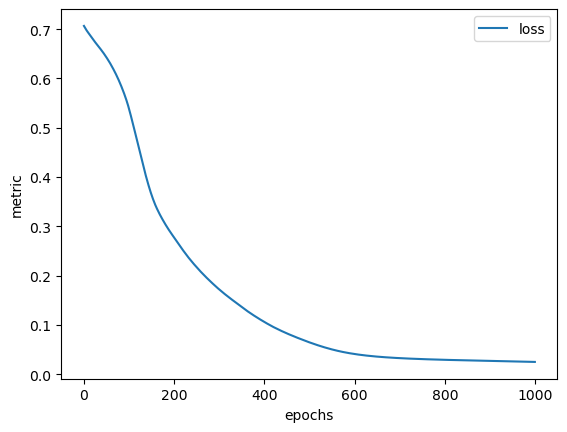

In [267]:
# call the plot_history function with the apropriate object and string
plot_history(history, ['loss'
                    #    , 'val_loss'
                       ]
                       ,0)

In [268]:
# # Save the model
# import os
# from datetime import datetime
# current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# # filename = f"{current_date}_RMSE_params_{model.count_params()}_points_{points}.keras"
# # model.save('models/'+filename)


# folder_path = f'models/{current_date}_{exponential_count}exp_params_{model.count_params()}_points_{points}'
# os.makedirs(folder_path, exist_ok=True)
# model.save(folder_path+'/model.keras')
# model.save(folder_path+'/model.h5')

In [269]:
# make prediction on test data
y_train_prediction = model.predict(X_train)
# y_test_prediction = model.predict(X_test)

1/1 [==============================] - 0s 37ms/step


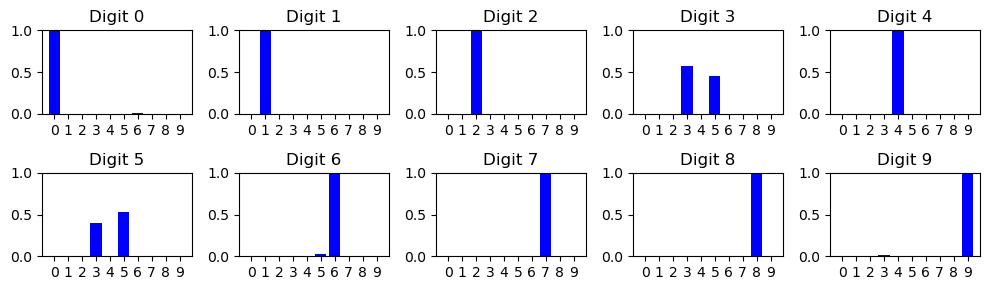

In [270]:
output= y_train_prediction
fig, axs = plt.subplots(ncols=output.shape[0]//2, nrows=2, figsize=(10, 3))

for j, ax in enumerate(axs):
    for i, ax in enumerate(ax):
        ax.bar(np.arange(10), output[j*5+i], color='blue')
        ax.set_ylim([0, 1])
        ax.set_xticks(np.arange(10))
        ax.set_title(f'Digit {j*5+i}')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'True vs predicted next step current (test data)')

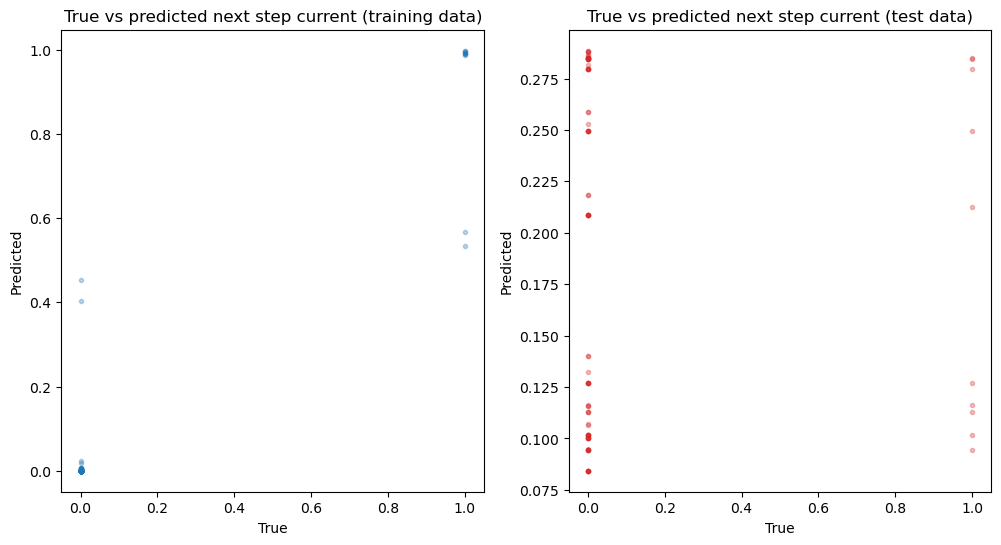

In [271]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(y_train, y_train_prediction, '.', color = 'C0', alpha = 0.3, )
# plt.legend()
    # plt.ylim(-1,1)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs predicted next step current (training data)')





plt.subplot(1, 2, 2)

plt.plot(y_test,y_test_prediction, '.', color = 'C3', alpha = 0.3, )
    
#plt.legend()
# plt.ylim(-1,1)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs predicted next step current (test data)')
# plt.savefig(f"{folder_path}/performance.png")

C:\Users\cierpind\AppData\Local\Temp\ipykernel_9400\2871207082.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(y_train, 1-np.abs(y_train_prediction-y_train)/y_train, '.', color = 'C0', alpha = 0.3, )
C:\Users\cierpind\AppData\Local\Temp\ipykernel_9400\2871207082.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.plot(y_test,1-np.abs(y_test_prediction-y_test)/y_test, '.', color = 'C3', alpha = 0.3, )


Text(0.5, 1.0, 'Accuracy of next step current prediction (test data)')

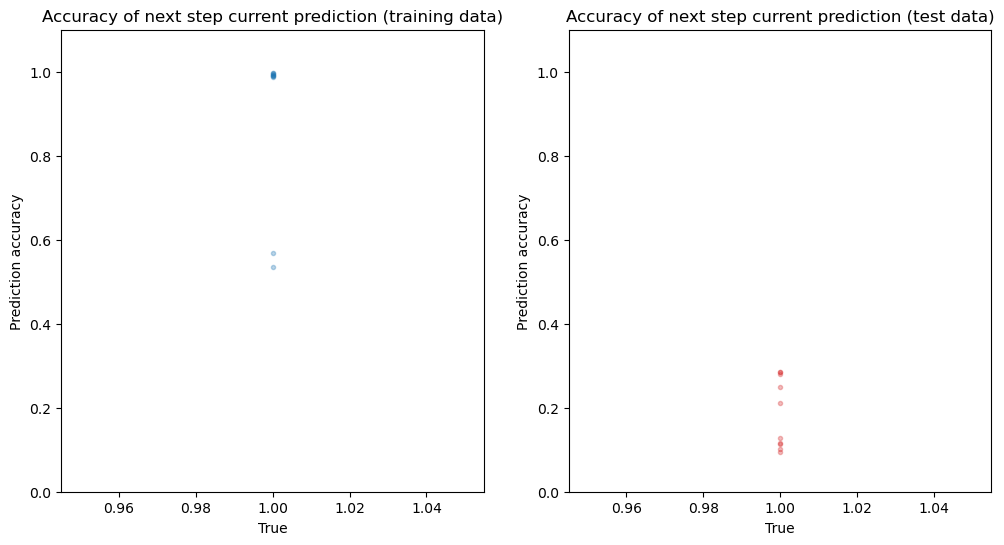

In [272]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(y_train, 1-np.abs(y_train_prediction-y_train)/y_train, '.', color = 'C0', alpha = 0.3, )
# plt.legend()
plt.ylim(0,1.1)
plt.xlabel('True')
plt.ylabel('Prediction accuracy')
plt.title('Accuracy of next step current prediction (training data)')





plt.subplot(1, 2, 2)

plt.plot(y_test,1-np.abs(y_test_prediction-y_test)/y_test, '.', color = 'C3', alpha = 0.3, )
    
#plt.legend()
plt.ylim(0,1.1)
plt.xlabel('True')
plt.ylabel('Prediction accuracy')
plt.title('Accuracy of next step current prediction (test data)')
# plt.savefig(f"{folder_path}/performance.png")